<b>This script requires astropy 3.0dev</b>

<h2>Fitting compound models using data normalization</h2>

In these experiments, we run the astropy fitters with the model components initialized to their default values provided by astropy, not to the data at hand as is currently done in specviz.

This is done using Thomas Robitaille's suggestion of using the units machinery in astropy to perform the fit on normalized data. In this way, all fitters will see a data set that exists in the range [-1:1] in both X and Y coordinates.

For comparison purposes, we also run the same fitters on the same data sets, using specviz's method of initialization based on the actual data. We also combine both techniques in a single procedure.

<b>Result: </b> 

These experiments suggest that the normalization technique is a viable alternative to providing initial guesses based on the actual data at hand. However, this can be said for now only for simple cases as the one tested here, where one component dominates the model. In more complex models with many spectral components, this approach of normalizing the data to [-1:1] remains to be tested yet.

These results also confirm that the SLSQP method requires the data to be normalized to the [-1:1] interval. 

L-M seems to be better behaved with normalized data, but also works (more or less), when using initial guesses instead. Simplex seems to be the other way around, behaving better when provided with initial guesses. 

We can also apply both procedures in sequence: first, find initial guesses from the data. Then, normalize both the model thus initialized, and the data. With that approach, SLSQP and Simplex appear to have outperformed L-M.

<b>Caveat: </b> 

Normalization cannot be implemented in specviz right now, since it depends on astropy v3.0 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().set_size_inches(8.,4.)

from astropy import units as u
from astropy.modeling import models, fitting


# This is basically Thomas Robitaille's example 
# normalization/fitting code, cast in the form 
# of utility functions.

def normalize_data(wave, flux):
    # Define custom units for x and y
    ux1 = u.def_unit('ux1')
    uy1 = u.def_unit('uy1')
    w1 = wave * ux1
    f1 = flux * uy1

    # Determine maximum values in each direction
    wmax = np.max(np.abs(w1.value))
    fmax = np.max(np.abs(f1.value))

    # Define new units so that in this system, the data is always in the range
    # [-1:1] in both directions and convert data to that frame.
    ux2 = u.Unit(wmax * w1.unit)
    uy2 = u.Unit(fmax * f1.unit)
    w2 = w1.to(ux2)
    f2 = f1.to(uy2)

    return w1, f1, w2, f2
    
def perform_fit(fitter, model, wave, flux, normalize=True):

    if not normalize:
        return fitter(model, wave, flux, maxiter=5000)  
    
    w1, f1, w2, f2 = normalize_data(wave, flux)
    
    # Strip away the units for the fitting
    w3 = w2.value
    f3 = f2.value

    # Run the fitting
    m3 = fitter(model, w3, f3, maxiter=5000)

    if hasattr(fitter, "fit_info") and 'message' in fitter.fit_info:
        print(fitter.fit_info['message'])

    # Add units to the parameters for the data that was fit, 
    # and then transform the parameters to the original units 
    # of the data
    m2 = m3.with_units_from_data(x=w2, y=f2)
    m1 = m2.without_units_for_data(x=w1, y=f1)

    return m1

In [2]:
# note that, to avoid clutter, these functons will plot just 
# one of the several data sets that contain the same spectral 
# components but different noise realizations.

def plot_1(w, fn, result, title, colors):
    plt.figure(figsize=(10, 3))
    plt.plot(w, fn, 'k.')
    for result, color in zip(result, colors):
        plt.plot(w, result(w), color)
    plt.title(title)    
    
def plot_2(w, f1_n, result_1, f2_n, result_2, title, colors):
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.plot(w, f1_n, 'k.')
    for result, color in zip(result_1, colors):
        plt.plot(w, result(w), color)
    plt.title(title + " - data set 1")    
    plt.subplot(122)
    plt.plot(w, f2_n, 'k.')
    for result, color in zip(result_2, colors):
        plt.plot(w, result(w), color)
    plt.title(title + " - data set 2")    

In [3]:
# Run one test: for a given fitter and model, fit two data sets. 
# Do the fit a number of times with different realizations of the 
# noise, so as to probe the fitter's sensitivity to noise.

def fit_and_plot(fitter, model, w, f1, f2, scale, normalize, title):
    # run the fitter six times, each time with a 
    # different noise realization.
    colors = ['-g','-c','-b','-y','-m','-r']
    
    result_1 = []
    for k in range(len(colors)):
        f1_n = f1 + scale / 10 * np.random.normal(0, 1, len(wave))
        result_1.append(perform_fit(fitter, model, w, f1_n, normalize))

    if f2 != None:
        result_2 = []
        for k in range(len(colors)):
            f2_n = f2 + scale / 10 * np.random.normal(0, 1, len(wave))
            result_2.append(perform_fit(fitter, model, w, f2_n, normalize))
            
    if f2 != None:
        plot_2(w, f1_n, result_1, f2_n, result_2, title, colors)    
    else:
        plot_1(w, f1_n, result_1, title, colors)    

In [4]:
def do_fits(model, wave, f1, f2, scale, normalize=True):
    fitter = fitting.LevMarLSQFitter()
    fit_and_plot(fitter, model, wave, f1, f2, scale, normalize, "L-M")

    fitter = fitting.SLSQPLSQFitter()
    fit_and_plot(fitter, model, wave, f1, f2, scale, normalize, "SLSQP")

    fitter = fitting.SimplexLSQFitter()
    fit_and_plot(fitter, model, wave, f1, f2, scale, normalize, "Simplex")

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2351335655643758
            Iterations: 132
            Function evaluations: 986
            Gradient evaluations: 131
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18092423674977678
            Iterations: 156
            Function evaluations: 1157
            Gradient evaluations: 155
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1990267462514767
            Iterations: 129
            Function evaluations: 960
            Gradient evaluations: 128
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2972344952254854
            Iterations: 121
            Function evaluations: 905
            Gradient evaluations: 120
Optimization terminated succ

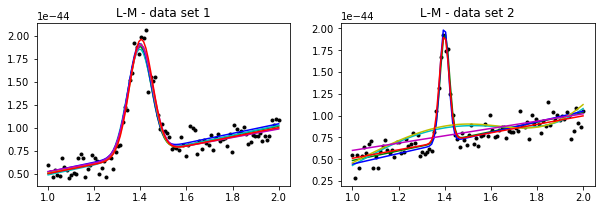

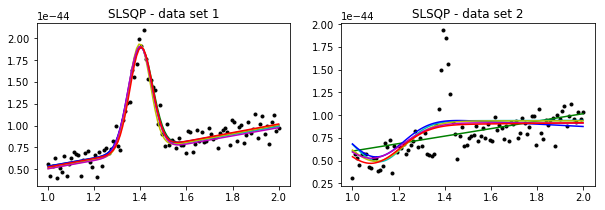

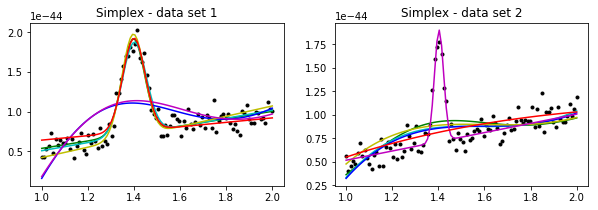

In [5]:
# Scale factor to make flux values look realistic (e.g in flam units)
SCALE = 1e-44

# Build two data sets with simulated Gaussian + linear components. The 
# data sets are identical except for the width of the Gaussian component: 
# data set 2 has a narrower Gaussian. 
#
# This is noiseless data, the test function adds actual noise realizations 
# to these data.
width1 = 0.05
width2 = 0.02
wave = np.linspace(1, 2, 100)
f1 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width1**2) +
      SCALE * (0.01 + 0.5 * wave))
f2 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width2**2) +
      SCALE * (0.01 + 0.5 * wave))

model = models.Gaussian1D() + models.Linear1D()

do_fits(model, wave, f1, f2, SCALE)

### Initial guesses

Lets now repeat the fits above, but in specviz's way, using first guesses derived from the data instead of normalization to [-1:1]. 

/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5323204891142526e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6103164929063468e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4772991064012532e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5548152419915228e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6117332555258085e-87
            Iterations: 1
            

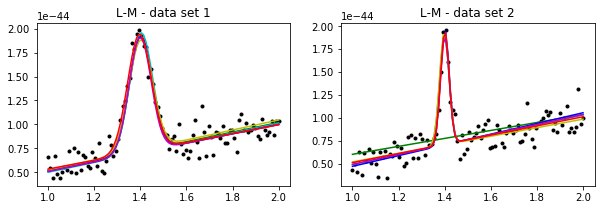

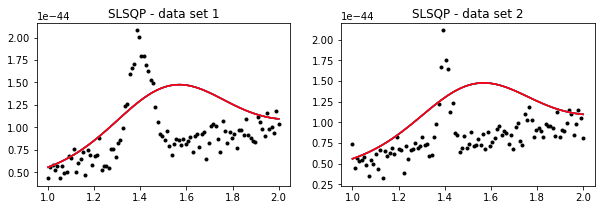

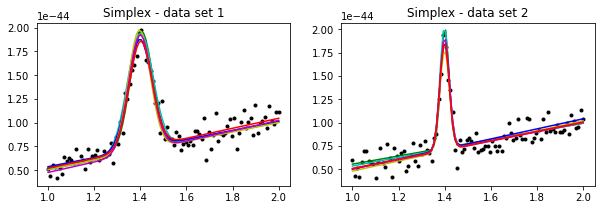

In [6]:
def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

h, c, s = initialize_gaussian(wave, f1)
gaussian = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(wave, f1)
linear = models.Linear1D(slope=s, intercept=i)

model = gaussian + linear

do_fits(model, wave, f1, f2, SCALE, normalize=False)

### Normalization plus initial guesses. 

Now we apply both corrections: first, find initial values and use them to build the model, and then normalize the data <b>and</b> the model.

This combined method may be necessary when dealing with more complex compound models. For instance, a model with two or more Gaussian components will need to be initialized from the data, with some manual intervention from the user. To fit such model with SLSQP, normalization will have to be used anyway. Even with Simplex and L-M, adding normalization to the fitting process probably wouldn't hurt either.

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at

/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19979028770370824
            Iterations: 22
            Function evaluations: 173
            Gradient evaluations: 22
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2441829136561423
            Iterations: 20
            Function evaluations: 159
            Gradient evaluations: 20
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2475827993396819
            Iterations: 22
            Function evaluations: 172
            Gradient evaluations: 22
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            

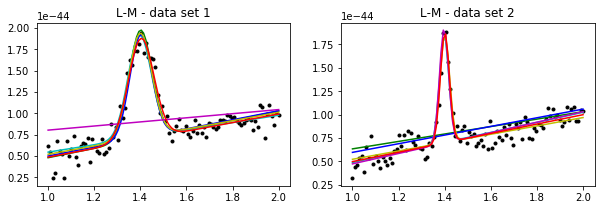

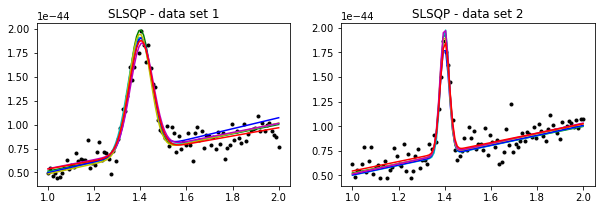

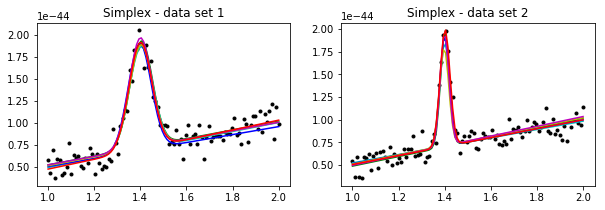

In [7]:
def normalize(model, wave, flux):

    w1, f1, w2, f2 = normalize_data(wave, flux)

    # note the subtle difference with the code in
    # perform_fit: here, we want to convert the input
    # model to the units of the already normalized
    # data, not to the units of the input data.

    m2 = model.with_units_from_data(x=w1, y=f1)
    m1 = m2.without_units_for_data(x=w2, y=f2)

    return m1
    
h, c, s = initialize_gaussian(wave, f1)
gaussian = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
gaussian_1 = normalize(gaussian, wave, f1)

s, i = initialize_linear(wave, f1)
linear = models.Linear1D(slope=s, intercept=i)
linear_1 = normalize(linear, wave, f1)

model = gaussian_1 + linear_1

do_fits(model, wave, f1, f2, SCALE, normalize=True)

### Multiple spectral components

Here we use normalization plus initial guesses to simultaneously fit two Gaussians and one linear ramp to specviz's test data.

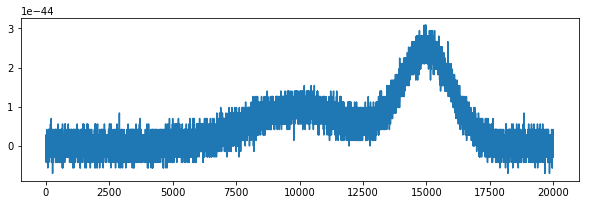

In [8]:
from astropy.io import fits

hdulist = fits.open('data/generic_spectra.fits')
flux = hdulist[1].data['flux'] * SCALE
wave = np.array(range(len(flux)))

plt.figure(figsize=(10, 3))
plt.plot(wave, flux)

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 110.18587036988242
            Iterations: 19
            Function evaluations: 229
            Gradient evaluations: 19
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 94.50303836472338
            Iterations: 21
            Function evaluations: 251
            Gradient evaluatio

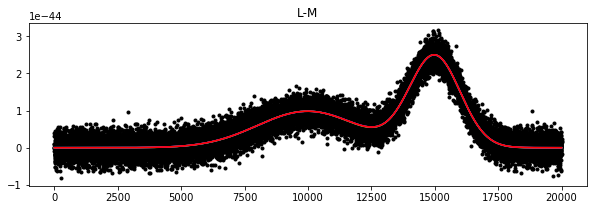

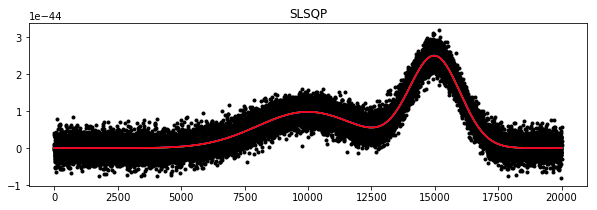

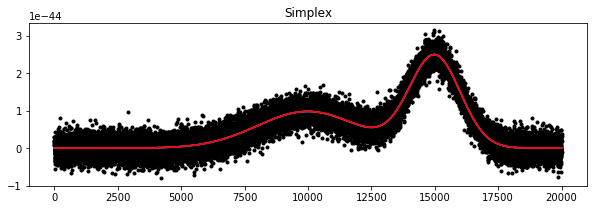

In [9]:
# each component parameter is first initialized to the data 
# region where the component is dominant. Next, each component
# is normalized wrt the entire data range. Then, the compound
# model is built from these initialized and normalized components.
# The data normalization step is performed only once, by the 
# fitter function itself.

i = np.array(list(range(6000,12500)))
h, c, s = initialize_gaussian(wave[i], flux[i])
gaussian = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
gaussian_1 = normalize(gaussian, wave, flux)

i = np.array(list(range(12500,17500)))
h, c, s = initialize_gaussian(wave[i], flux[i])
gaussian = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
gaussian_2 = normalize(gaussian, wave, flux)

i = np.array(list(range(0,2500)) + list(range(17500,19900)))
s, i = initialize_linear(wave[i], flux[i])
linear = models.Linear1D(slope=s, intercept=i)
linear_1 = normalize(linear, wave, flux)

model = gaussian_1 + gaussian_2 + linear_1

do_fits(model, wave, flux, None, SCALE, normalize=True)

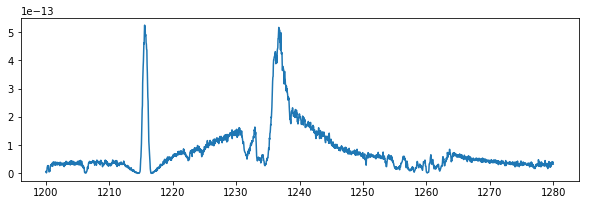

In [21]:
hdulist = fits.open('data/combined_13330_G130M_v40_bin4.fits')
flux = hdulist[1].data['flux'][0]
wave = hdulist[1].data['wavelength'][0] 

i1 = np.where(wave < 1280.)
i2 = np.where(wave[i1] > 1200.)
w = wave[i2]
f = flux[i2]

plt.figure(figsize=(10, 3))
plt.plot(w, f)